# Basic Plotting

For the atmospheric data, we will look at common variables in the atmospheric diagnostics. Some of the plotting in these examples are based on the <a href="https://github.com/NCAR/ADF">AMWG diagnostic framework (ADF)</a> and some are natively from the `xarray` functionality.


let's go over 3 basic plotting examples:

Exercise 1: Global lat/lon of surface temperature

Exercise 2: Zonal mean of short wave cloud forcing

Exercise 3: Temperature zonal mean with vertical levels

`xarray` will be used for the data I/O, analysis, and some plotting, `matplotlib` and `cartopy` will aid in plotting, and `numpy` for calculations

In [2]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import os

The first steps are to grab an atmosphere history file

Note: Use the file `b1850_high_freq.cam.h0.0001-01.nc` located at `/glade/scratch/hannay/archive/b1850_high_freq/atm/hist/`

In [3]:
# Here we point to the dataset
monthly_output_path = "/glade/scratch/hannay/archive/b1850_high_freq/atm/hist"
run_name = "b1850_high_freq.cam.h0.0001-01.nc"

files = os.path.join(monthly_output_path,
                         run_name)
files

'/glade/scratch/hannay/archive/b1850_high_freq/atm/hist/b1850_high_freq.cam.h0.0001-01.nc'

In [4]:
ds = xr.open_dataset(files)

<xarray.Dataset>
Dimensions:           (lat: 96, lon: 144, lev: 32, ilev: 33, time: 1, nbnd: 2)
Coordinates:
  * lat               (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon               (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lev               (lev) float64 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev              (ilev) float64 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time              (time) object 0001-02-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/401)
    gw                (lat) float64 ...
    hyam              (lev) float64 ...
    hybm              (lev) float64 ...
    P0                float64 ...
    hyai              (ilev) float64 ...
    hybi              (ilev) float64 ...
    ...                ...
    soa_c1            (time, lev, lat, lon) float32 ...
    soa_c1DDF         (time, lat, lon) float32 ...
    soa_c1SFWET       (time, lat, lon) float32 ...
    soa_c2            (time, lev, lat, lon) float32 ...
    soa_c2DDF         (time, lat, lon) float32 ...
    soa_c2SFWET       (time, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b1850_high_freq
    logname:           hannay
    host:              cheyenne2
    initial_file:      b.e20.B1850.f19_g17.release_cesm2_1_0.020.cam.i.0301-0...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_1.9x2...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

## Exercise 1: Make a lat-lon plot of TS

To highlight plotting the variables from the CESM atmosphere file, the fisrt example will plot a simple global lat/lon plot of surface temperature `TS`

### Grab data from first time stamp

NOTE: This dataset has <em>only</em> one time

In [8]:
ts_0 = ds.TS.sel({'time':ds.TS.time.values[0]}).squeeze()
ts_0

<xarray.DataArray 'TS' (lat: 96, lon: 144)>
[13824 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    time     object 0001-02-01 00:00:00
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean

Next is to set up the map. Since we are plotting a global lat/lon, we will use the Plate Carree projection. 

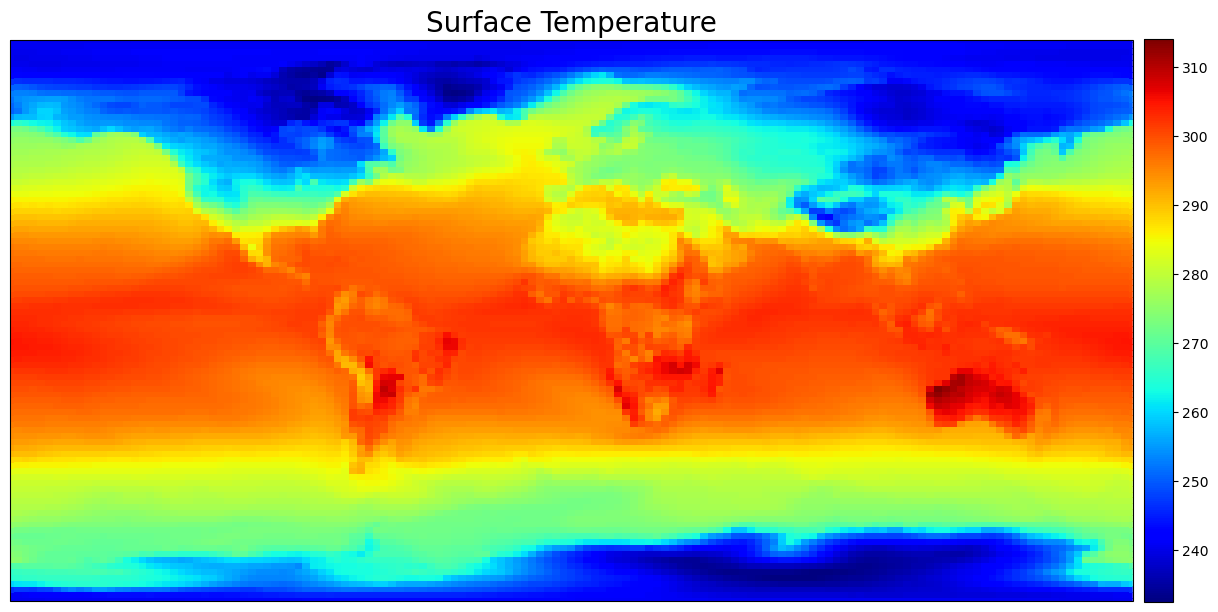

In [9]:
# define the colormap
cmap = plt.cm.get_cmap('jet')  

# set up the figure with a Plate Carree projection
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

#Plot the first timeslice of TS
img=ax.pcolormesh(ds.lon,
                   ds.lat,
                   ds.TS.sel({'time':ts_0}).squeeze(),
                   cmap=cmap,
                   transform=ccrs.PlateCarree())

plt.title("Surface Temperature",fontsize=20)

# Set up colorbar
plt.colorbar(img,orientation='vertical',fraction=0.0242,pad=0.01)
plt.show()

#### Question:

What code would you use in the `pcolormesh` function to set the plotting limits?

#### Question:

How could we change the central longitude?

#DROPDOWN ?

```python
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=0))
```

A second quick example is for `xarray`'s built-in plotting which uses the `matplotlib` and `cartopy` in the background. `xarray` makes a basic plot fairly simple.

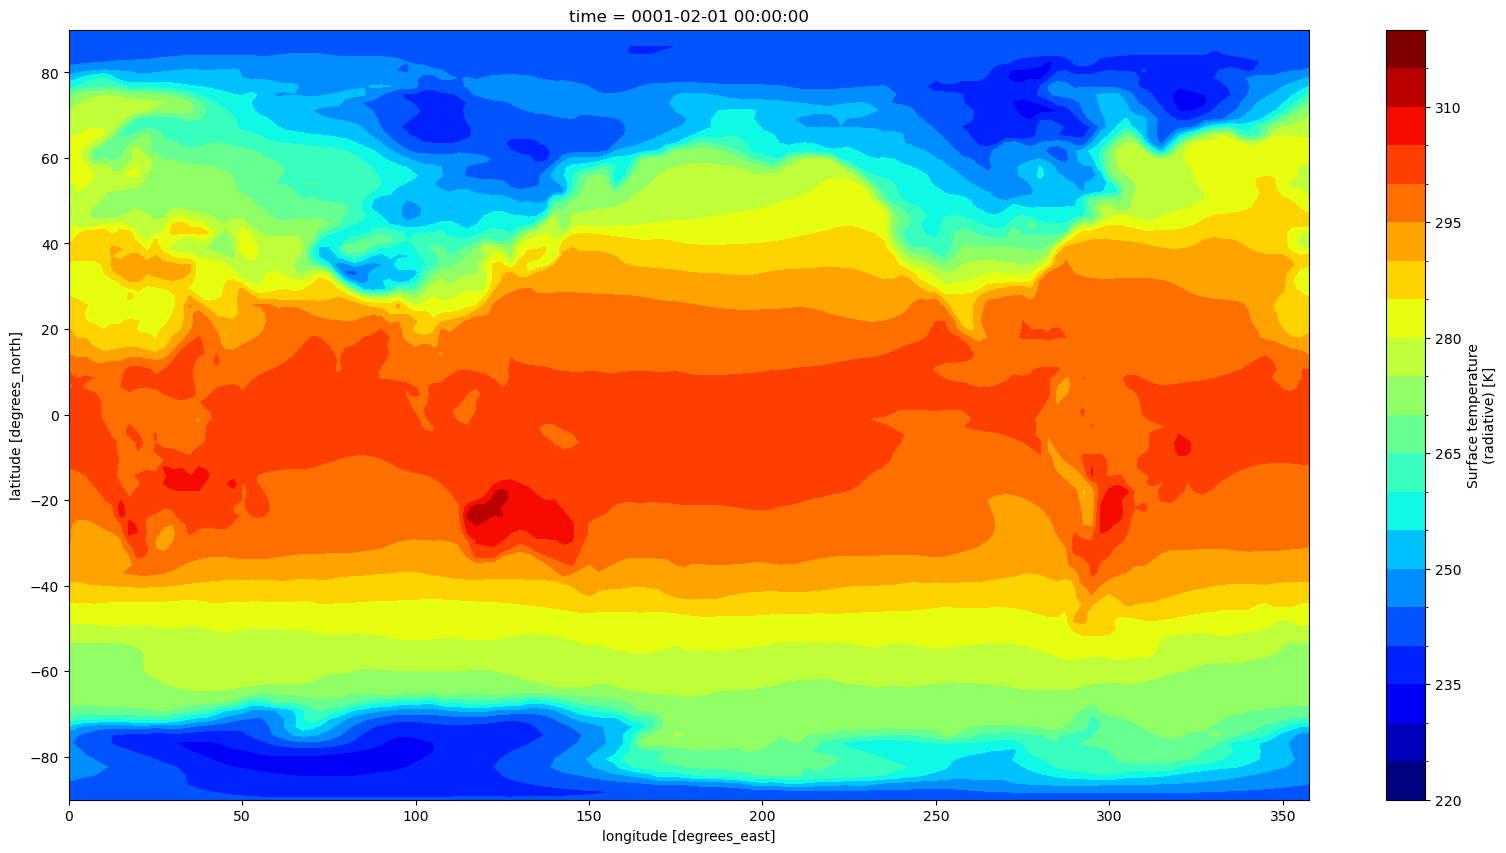

In [10]:
# Xarray native plotting

# Grab the first time stamp
ts = ds.TS.sel({'time':ts_0}).squeeze()

# Set up figure and axis
fig, ax = plt.subplots(1,figsize=(20,10))

# Plot the data straight from the xarray dataset
ts.plot.contourf(cmap="jet",levels=np.arange(220,321,5))

plt.show()

---

## Exercise 2: Zonal plot of SWCF

The second example plot will plot the short cloud cloud forcing `SWCF` zonally.

Grab the variable data and mean over the the lon value

In [34]:
ds_swcf = ds.SWCF

# Get all the dataset dimensions
d = ds_swcf.dims

# Grab all dimensions to mean the lon values from
davgovr = [dim for dim in d if dim not in ('lev','lat')]

# Make new dataset of zonal mean valaues
ds_swcf_zonal = ds_swcf.mean(dim=davgovr)

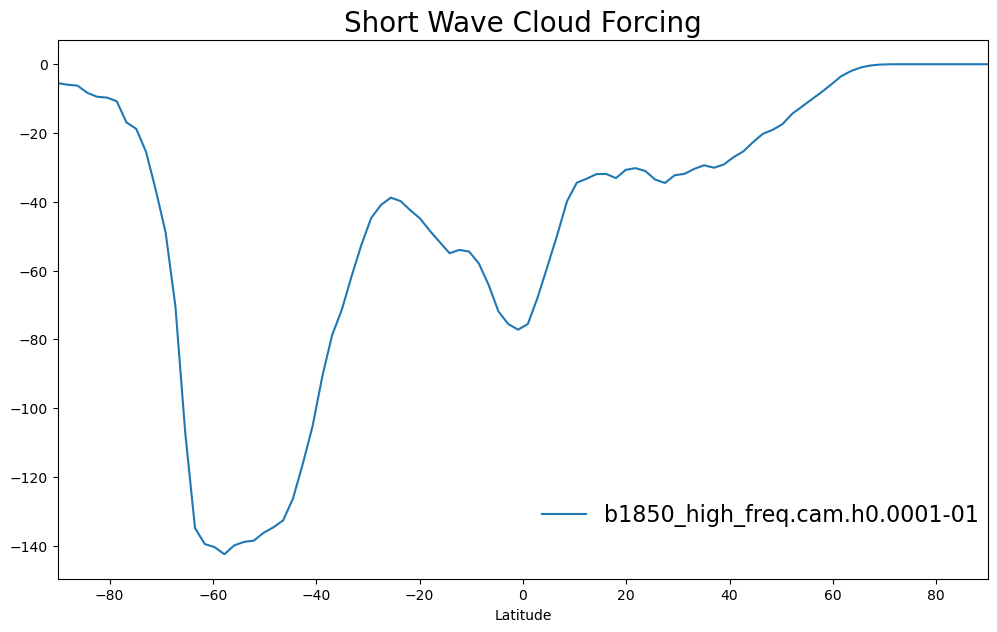

In [35]:
# Create figure and axis
fig, ax = plt.subplots(1,figsize=(12,7))

# Set Main title for subplots:
plt.title("Short Wave Cloud Forcing",fontsize=20)

# Plot value on y-axis and latitude on the x-axis
ax.plot(ds_swcf_zonal.lat, ds_swcf_zonal, c="#1f77b4")

ax.set_xlim([max([ds_swcf_zonal.lat.min(), -90.]), min([ds_swcf_zonal.lat.max(), 90.])])

ax.set_xlabel("Latitude")
plt.show()

### Question

What code could you add to set legend for plot line?

#DROPDOWN ?

```python
label = ds_swcf.time.values[0].strftime() # -> '0001-02-01 00:00:00'
line = Line2D([0], [0], label=label,
                        color="#1f77b4")
                        
fig.legend(handles=[line],bbox_to_anchor=(-0.15, 0.15, 1.05, .102),loc="right",
                   borderaxespad=0.0,fontsize=16,frameon=False)
```

What else could go for the line legend, if anything?
#DROPDOWN ?
-> suimulation run name, season, etc.

---

## Exercise 3: Plot of zonal T

This example will plot the 3D zonal mean of temperature `T` with the pressure as the y-variable and latitude as the x-variable


```{warning}
QUESTION FOR REVIEWERS: Here are four examples of how to plot the data. I think each is valuable for plotting pressure on the y-axis and changing the y-tick scale (ie log) to get more information out of the data. 

I've added two different ways of plotting: native xarray and what the ADF uses. 

Let me know about any feedback on these, I'm sure these could be turned into exercises?

```

In [18]:
ds_t = ds.T.squeeze()

#### Natively via xarray

 - y-axis is <strong>increasing</strong> with height
 - y-axis is <strong>not</strong> in log pressure

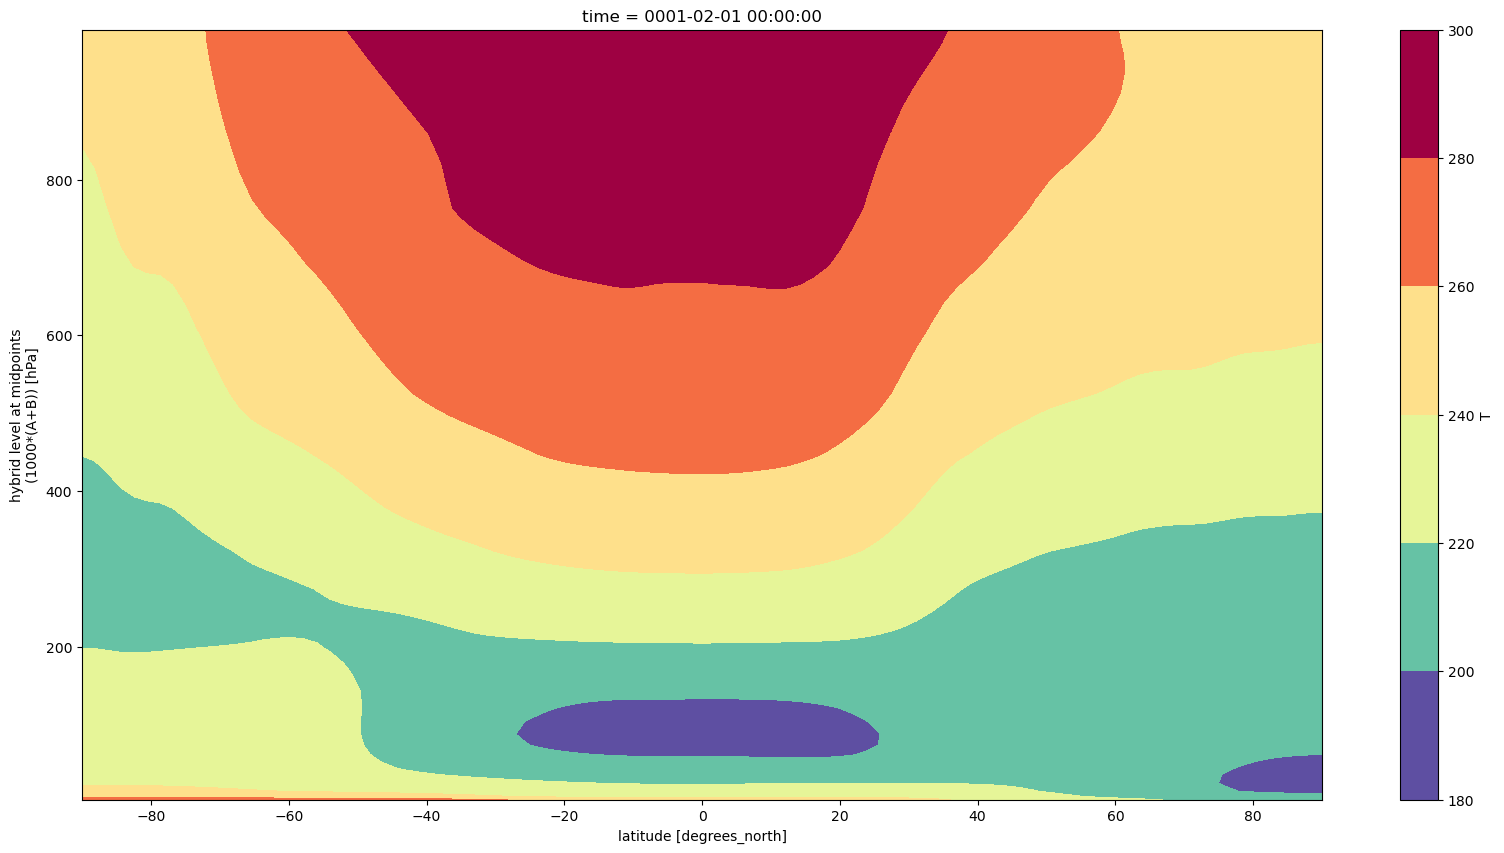

In [30]:
#Average over all dimensions except `lev` and `lat`.
d = ds_t.dims
davgovr = [dim for dim in d if dim not in ('lev','lat')]

DS = ds_t.mean(dim=davgovr)
DS.transpose('lat', 'lev',...)
fig, ax = plt.subplots(1,figsize=(20,10))
DS.plot.contourf(ax=ax, y='lev',cmap="Spectral_r")
plt.show()

#### ADF style quick plot

 - y-axis is <strong>increasing</strong> with height
 - y-axis is <strong>not</strong> in log pressure

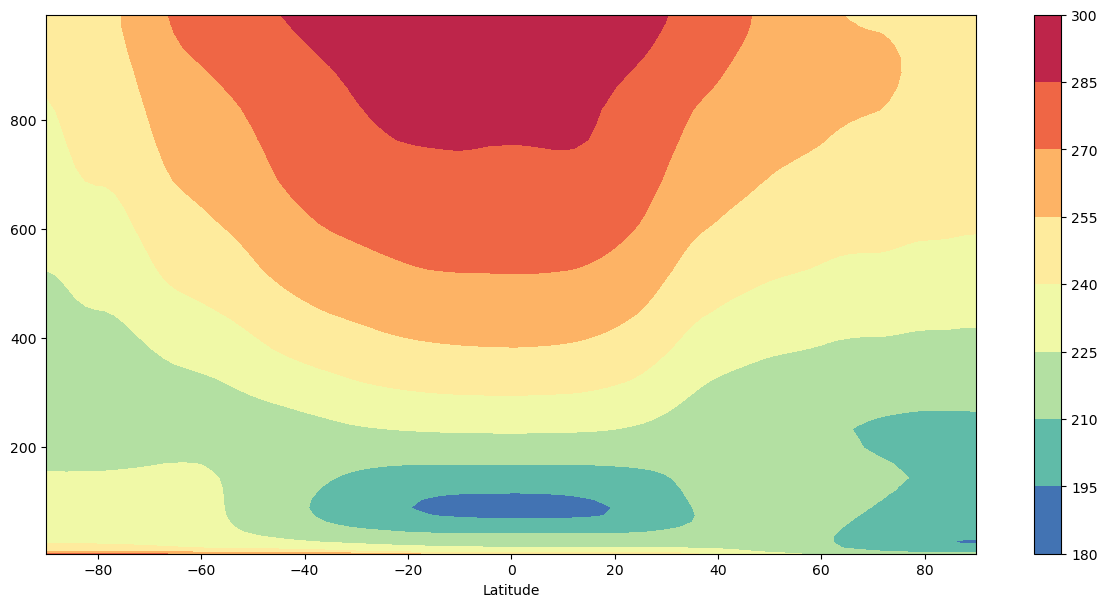

In [31]:
#Average over all dimensions except `lev` and `lat`.
d = ds_t.dims
davgovr = [dim for dim in d if dim not in ('lev','lat')]

DS = ds_t.mean(dim=davgovr)

lev = DS['lev']
lat = DS['lat']
mlev, mlat = np.meshgrid(lev, lat)

# Generate zonal plot:
fig, ax = plt.subplots(1,figsize=(15,7))

# Create zonal plot with vertical levels 
img = ax.contourf(mlat, mlev, DS.transpose('lat', 'lev'), cmap='Spectral_r')

# Format axis and ticks
ax.set_xlabel("Latitude")
fig.colorbar(img, ax=ax, location='right')

#### Same as above, but:

 - y-axis is <strong>decreasing</strong> with height
 - y-axis is <strong>not</strong> in log pressure

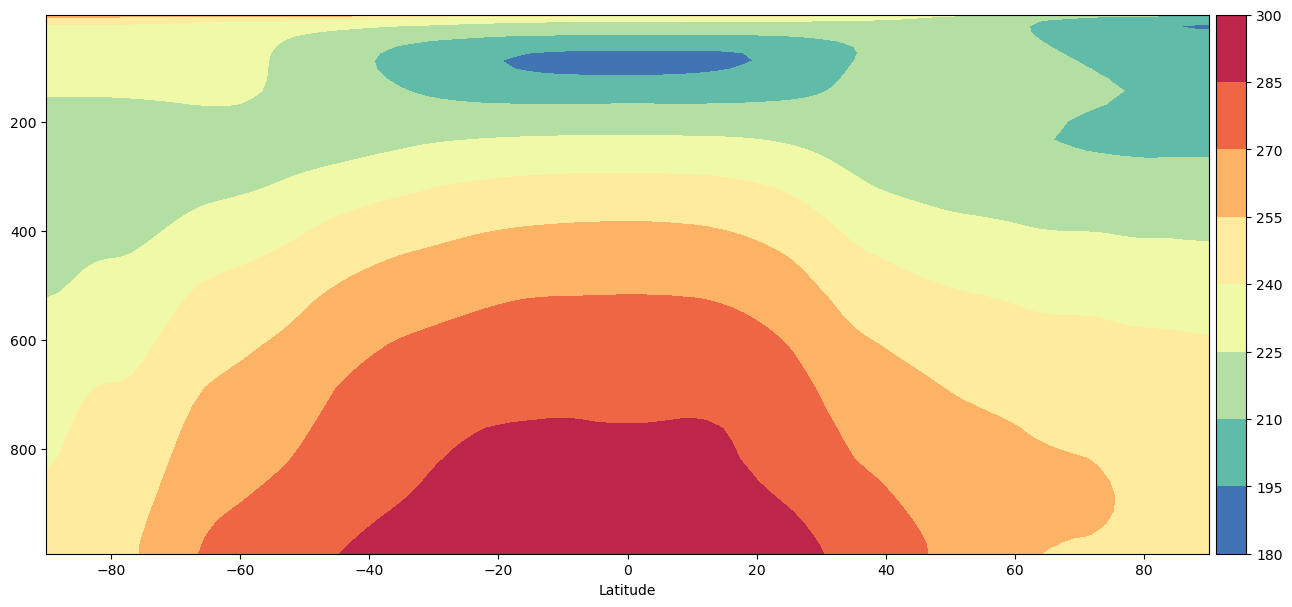

In [16]:
#Average over all dimensions except `lev` and `lat`.
d = ds_t.dims
davgovr = [dim for dim in d if dim not in ('lev','lat')]

DS = ds_t.mean(dim=davgovr)

#print(DS.lev.min(),DS.lev.max())

lev = DS['lev']
lat = DS['lat']
mlev, mlat = np.meshgrid(lev, lat)

# Generate zonal plot:
fig, ax = plt.subplots(1,figsize=(15,7))

# Create zonal plot with vertical levels 
img = ax.contourf(mlat, mlev, DS.transpose('lat', 'lev'), cmap='Spectral_r')

# Format axis and ticks
plt.gca().invert_yaxis()
ax.tick_params(which='minor', length=4, color='r')

# Set up colorbar
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
posn = ax.get_position()

#Set position and size of colorbar position: [left, bottom, width, height]
cbar_ax.set_position([posn.x0 + posn.width + 0.005, posn.y0,
                          0.02, posn.height])

ax.set_xlabel("Latitude")
fig.colorbar(img, cax=cbar_ax,orientation='vertical')

#### Same as above, but:

 - y-axis is <strong>decreasing</strong> with height
 - y-axis <strong>is</strong> in log pressure

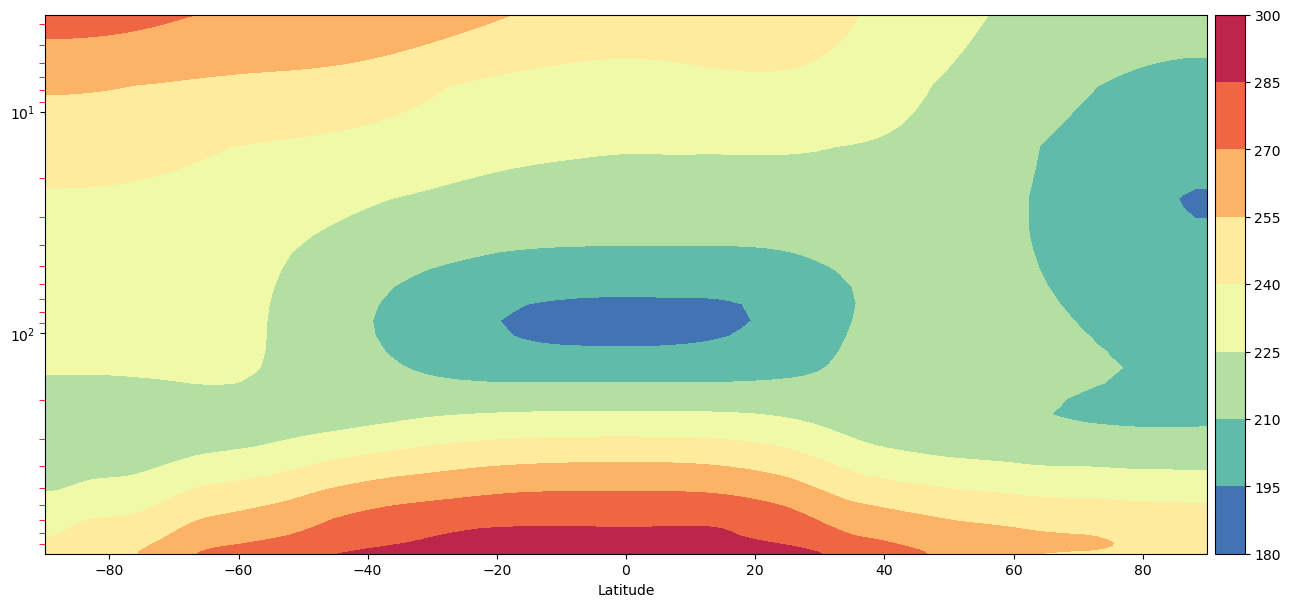

In [17]:
#Average over all dimensions except `lev` and `lat`.
d = ds_t.dims
davgovr = [dim for dim in d if dim not in ('lev','lat')]

DS = ds_t.mean(dim=davgovr)

#print(DS.lev.min(),DS.lev.max())

lev = DS['lev']
lat = DS['lat']
mlev, mlat = np.meshgrid(lev, lat)

# Generate zonal plot:
fig, ax = plt.subplots(1,figsize=(15,7))

# Create zonal plot with vertical levels 
img = ax.contourf(mlat, mlev, DS.transpose('lat', 'lev'), cmap='Spectral_r')

# Format axis and ticks
plt.yscale("log")
plt.gca().invert_yaxis()
ax.tick_params(which='minor', length=4, color='r')

# Set up colorbar
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
posn = ax.get_position()

#Set position and size of colorbar position: [left, bottom, width, height]
cbar_ax.set_position([posn.x0 + posn.width + 0.005, posn.y0,
                          0.02, posn.height])

ax.set_xlabel("Latitude")
fig.colorbar(img, cax=cbar_ax,orientation='vertical')